<a href="https://colab.research.google.com/github/jnramirezg/medio_continuo/blob/main/codigo/27-diseno_concreto_reforzado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 27. Diseño esquemático de concreto reforzado

|Quién | Fecha | Qué hizo |
| ---  | ---   | ---      |
|Juan Nicolás Ramírez, <jnramirezg@unal.edu.co> | 2022-11-22 | Creando código y traduciendo código|

Importamos las librerías necesarias:

In [1]:
from numpy import *
from matplotlib.pyplot import *

## **(7) Propiedades**

Propiedades geométricas de la viga:

In [2]:
b = 0.40             # [m] Ancho de la viga.
h = 0.70             # [m] Altura de la viga
L = 10               # [m] Longitud de viga.
I = b*h**3/12        # [m4] Inercia de la sección.

Propiedades del material:

In [3]:
fpc = 21             # [MPa] Resistencia a compresión del concreto.
E = 4700*(fpc)**0.5  # [MPa] NSR-10 (C.8.5).
E = E*1000           # [kN/m2=kPa].
nu = 0.23            # Coeficiente de Poisson.
G = E/(2*(1 + nu))   # [kN/m2] Módulo de cortante.

Estimación de cargas:

In [4]:
q = -30              # [kN/m] carga distribuida.

## **(8) Chequeo de deflexiones**

Comparamos las deflexiones máximas de las luces de la viga con la máxima admisible permitida por la NSR-10, que vienen dadas por expreciones de la forma L/factor. Donde factor dependiendo de las condiciones de apoyo es 180, 360 o 480; el caso de $L/480$ es el más exigente.

In [5]:
vmax = 5*q*L**4/(384*E*I)
vmax

-0.01586279325850156

In [6]:
vadm = -L/480
vadm

-0.020833333333333332

Debemos verificar que $$v_{adm} \geq v_{máx}$$

## **(9) Cálculo de esfuerzos**

Definimos una malla de evaluación en el plano xy, en este caso de tamaño $(20,10)$:

In [7]:
x, y = meshgrid(linspace(   0,   L, 20),  # Dirección x.
                linspace(-h/2, h/2, 10))  # Dirección y, va de -h/2 hasta h/2 porque el eje neutro está en y=0.

Calculamos en la malla de (20, 10) puntos, los cortantes $V(x)$ y los momentos $M(x)$, cuyas ecuaciones fueron calculadas a mano:
$$V(x)=qx-\frac{1}{2}qL$$
$$M(x)=\frac{1}{2}q(x^2-Lx)$$

In [8]:
V = q*x - q*L/2      # [kN]
M = q/2*(x**2- L*x)  # [kN.m]

Calculamos en la malla de $(20, 10)$ los esfuerzos $\sigma_x$ y $\tau_{xy}$ según la teoría de vigas de Euler-Bernoulli con las ecuaciones:
$$\sigma_x(x,y) = \frac{M(x)y}{I}$$
$$\tau_{xy}(x,y)=\frac{V}{2I}{(y^2-\frac{h^2}{2})}$$

Y usamos la siguiente ecuación válida para vigas con secciones simétricas respecto a $y=0$ (no explicada en clase): 

$$\sigma_y(x,y)=\frac{q(x)}{2b(y)h}(2y+h)$$

In [9]:
sx = -M*y/I                  # [kN/m2]     
txy = V*(y**2-h**2/4)/(2*I)  # [kN/m2]
sy = q*(2*y+h)/(2*b*h)       # [kN/m2]

## **(10) Cálculo de deformaciones**

Debido a que:

$$\displaystyle \underline{\underline{\boldsymbol{\sigma}}} = \left[\begin{matrix}\sigma_{x} & \tau_{xy} & 0\\\tau_{xy} & \sigma_{y} & 0\\0 & 0 & 0\end{matrix}\right]$$

Calculamos las deformaciones con las ecuaciones de **tensión plana** para isótropos:
$$\varepsilon_x=\frac{1}{E}(\sigma_x-\nu \sigma_y)$$

$$\varepsilon_y=\frac{1}{E}(\sigma_y-\nu \sigma_x)$$

$$\varepsilon_z=-\frac{\nu}{E}(\sigma_x+\sigma_y)$$

$$\gamma_{xy}=\frac{1}{G}\tau_{xy}$$

$$\gamma_{yz}=0$$

$$\gamma_{xz}=0$$

Calculamos en la malla de (20,10):

In [10]:
ex = (1/E)*(sx - nu*sy)
ey = (1/E)*(sy - nu*sx)
ez = -(nu/E)*(sx + sy)
gxy = txy/G

## **(11) Cálculo de esfuerzos y direcciones principales**

Calculamos los esfuerzos y direcciones principales a partir de las ecuaciones del capítulo 2, para la malla de (20, 10):

$$\sigma_1=\frac{(\sigma_x+\sigma_y)}{2}+\tau_{max}$$
$$\sigma_2=\frac{(\sigma_x+\sigma_y)}{2}-\tau_{max}$$

Donde: $\tau_{máx}=R=\sqrt{\left(\frac{\sigma_x-\sigma_y}{2}\right)^2 + \tau_{xy}^2}$

$$\theta_1=\arctan\left(\frac{\tau_{xy}}{\frac{\sigma_x-\sigma_y}{2}}\right)$$

$$\theta_2=\arctan\left(\frac{-\tau_{xy}}{-\frac{\sigma_x-\sigma_y}{2}}\right)$$


In [11]:
tmax = sqrt(((sx - sy)/2)**2 + txy**2)
s1 = (sx+sy)/2 + tmax
s2 = (sx+sy)/2 - tmax
t1 = arctan2(2*txy, sx-sy)/2  
t2 = arctan2(-2*txy, -(sx-sy))/2

---

Creamos una función que permita graficar los esfuerzos y las deformaciones:

In [12]:
def dibujar_esf_def(titulo, f, x, y, angulo=None):
    curvas = linspace(f.min(), f.max(), 20)  # Definimos 20 curvas de nivel. 
    figure(figsize=(20, 4))
    im = pcolormesh(x, y, f, vmin=f.min(), vmax=f.max(), shading='gouraud', cmap='jet_r')
    # Para los esfuerzos principales se grafican las líneas que indiquen las
    # direcciones de los esfuerzos en cada nodo de la malla.
    if angulo is not None:
        escala_ang = abs(f)**(1/3)  # Escalamos la magnitud del ángulo.
        if type(angulo) is ndarray:
            angulo = [angulo]
        for i in angulo:
            # Dibujamos las direcciones.
            quiver(x, y, escala_ang*cos(i), escala_ang*sin(i), headwidth=0, headlength=0, headaxislength=0, pivot="middle")  
    # Se grafica la función con colores.
    contour(x, y, f, levels=curvas, colors='k', linestyles='-', linewidths=0.7)
    colorbar(im, aspect=5)       # Se crea una barra de color lateral.
    ylabel(titulo, fontsize=18)  # Título.
    xlim(x.min(), x.max())       # Límites en x del gráfico.
    ylim(y.min(), y.max())       # Límites en y del gráfico.
    show()

## **(12) Gráficas de esfuerzos**

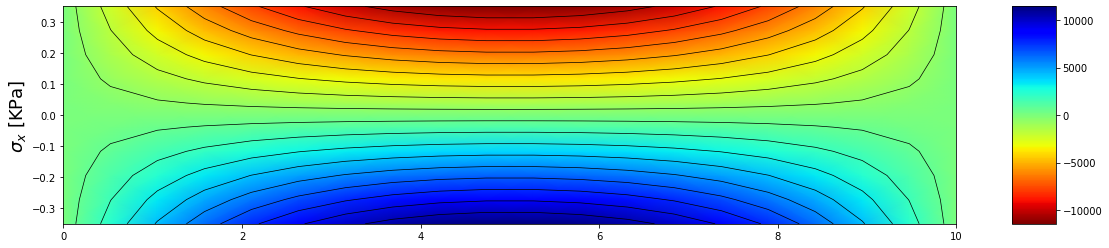

In [13]:
dibujar_esf_def(r"$\sigma_x$ [KPa]", sx, x, y)

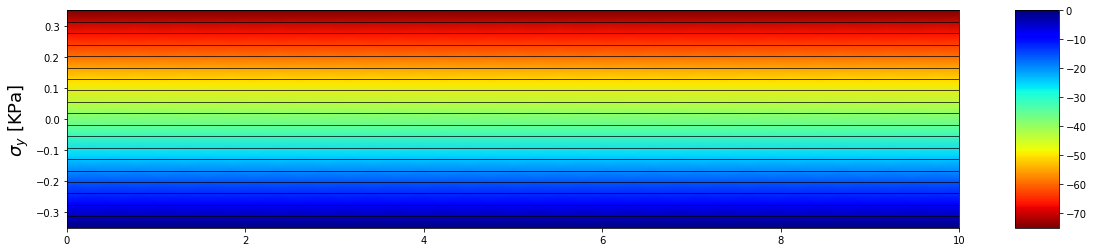

In [14]:
dibujar_esf_def(r"$\sigma_y$ [KPa]", sy, x, y)

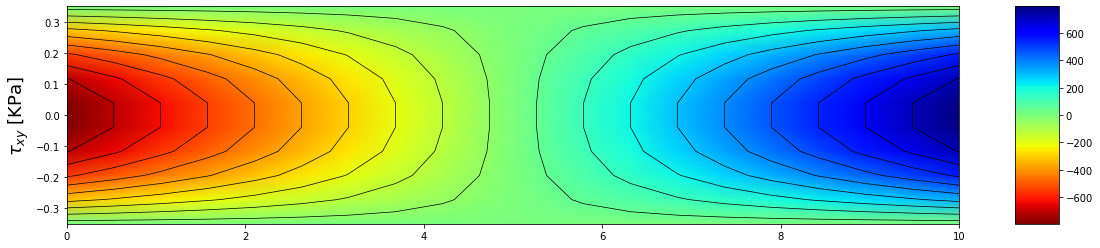

In [15]:
dibujar_esf_def(r"$\tau_{xy}$ [KPa]", txy, x, y)

## **(13) Gráficas de deformaciones**

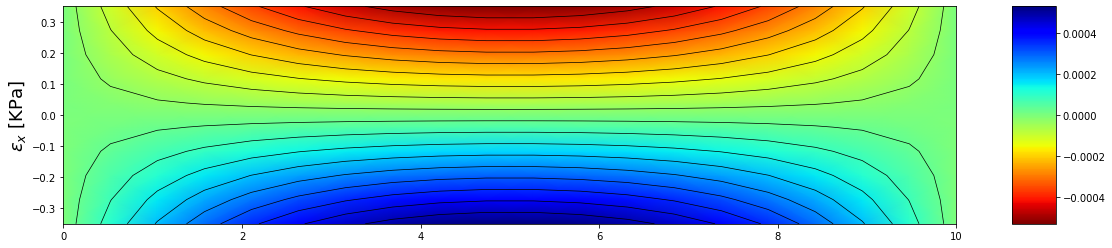

In [16]:
dibujar_esf_def(r"$\varepsilon_x$ [KPa]", ex, x, y)

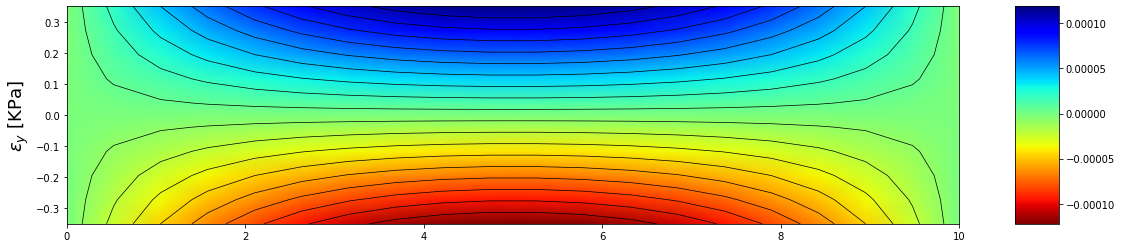

In [17]:
dibujar_esf_def(r"$\varepsilon_y$ [KPa]", ey, x, y)

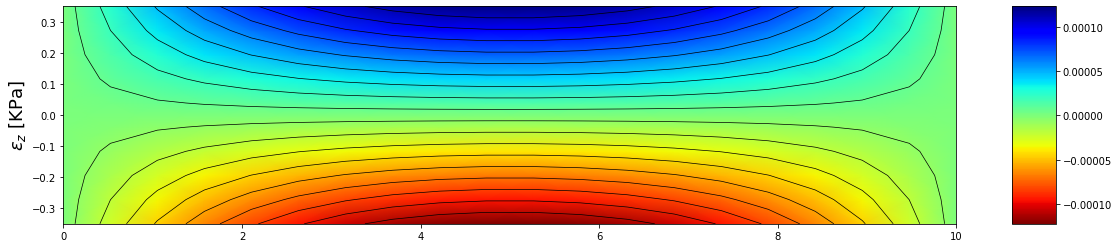

In [18]:
dibujar_esf_def(r"$\varepsilon_z$ [KPa]", ez, x, y)

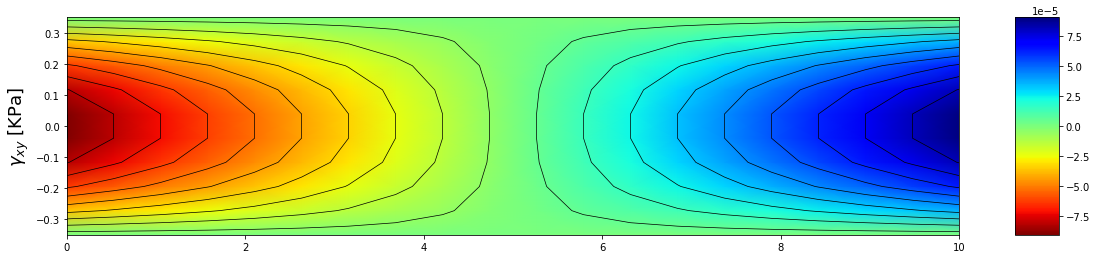

In [19]:
dibujar_esf_def(r"$\gamma_{xy}$ [KPa]", gxy, x, y)

## **(14) Gráficas de esfuerzos y direcciones principales**

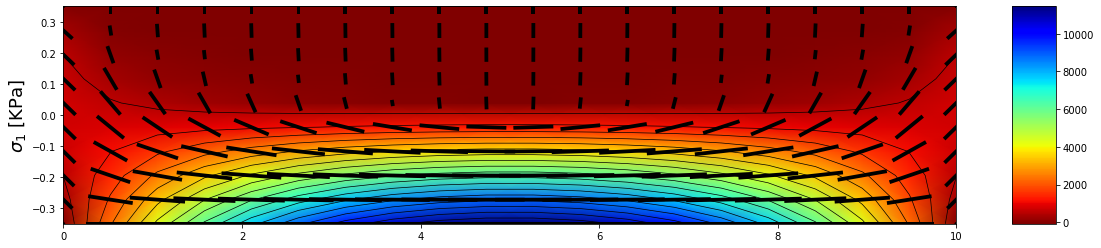

In [20]:
dibujar_esf_def(r"$\sigma_1$ [KPa]", s1, x, y, t1)

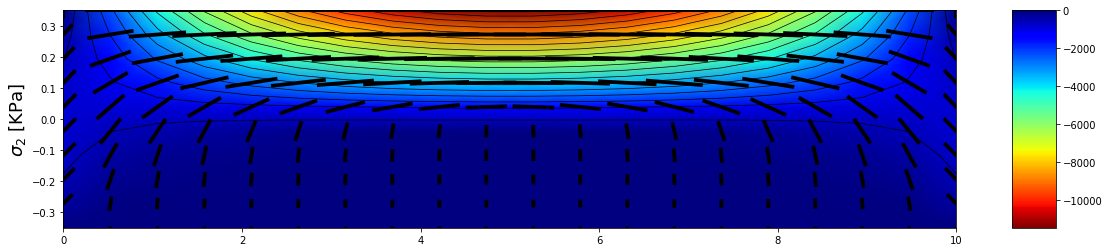

In [21]:
dibujar_esf_def(r"$\sigma_2$ [KPa]", s2, x, y, t2)

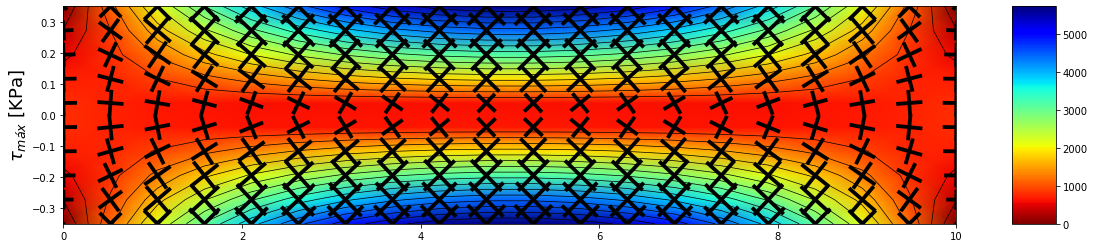

In [22]:
dibujar_esf_def(r"$\tau_{máx}$ [KPa]", tmax, x, y, [t1-pi/4, t1+pi/4])

# **(17) Conclusiones:**

Diseñar con $M(x)$ y $V(x)$ es equivalente a hacerlo con $\sigma_1$.

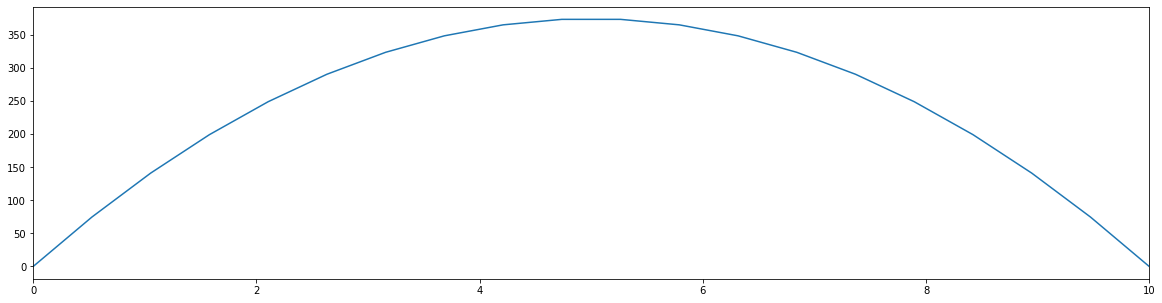

In [23]:
figure(figsize=(20, 5))
plot(x[0], M[0])
xlim(0, L)
show()

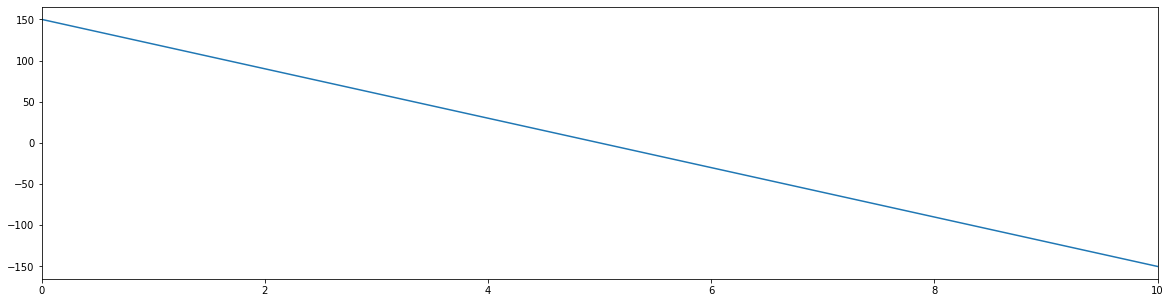

In [24]:
figure(figsize=(20, 5))
plot(x[0], V[0])
xlim(0, L)
show()

Creamos nuevamente nuestras variables, pero ahora, como funciones de x.

In [25]:
V = lambda x: q*x - q*L/2
M = lambda x: q/2*(x**2- L*x)
sx = lambda x,y: -M(x)*y/I
sy = lambda x,y: sx(x,y)*0
txy = lambda x,y: V(x)*(y**2-h**2/4)/(2*I)
tmax = lambda x, y: sqrt(((sx(x,y) - sy(x,y))/2)**2 + txy(x,y)**2)
s1 = lambda x, y: (sx(x,y)+sy(x,y))/2 + tmax(x,y)

Responsable del esfuerzo principal $\sigma_1$ cerca a los apoyos (0, 0):

In [37]:
sx(0, 0)

0.0

In [38]:
txy(0, 0)

-803.5714285714287

In [28]:
s1(0, 0)

803.5714285714287

Responsable del esfuerzo principal $\sigma_1$ en el centro de la luz de la viga, fibra inferior (L, -h/2):

In [29]:
sx(L/2, -h/2)

11479.591836734697

In [30]:
txy(L/2, -h/2)

0.0

In [31]:
s1(L/2, -h/2)

11479.591836734697

En el centro de toda la viga, teóricamente no hay esfuerzos:

In [32]:
sx(L/2, 0)

-0.0

In [33]:
txy(L/2, 0)

-0.0

In [34]:
s1(L/2, 0)

0.0

Valores máximos:

In [39]:
s1(x,y).max()

11447.792413364241

In [36]:
txy(x,y).max()

793.6507936507937